# Proyecto Sprint 15

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

Aquí se describen los campos seleccionados:

- review: el texto de la reseña
- pos: el objetivo, '0' para negativo y '1' para positivo
- ds_part: 'entrenamiento'/'prueba' para la parte de entrenamiento/prueba del conjunto de datos, respectivamente

## Objetivo

1. Construir tres modelos para clasificar las reseñas positivas y negativas
2. Alcanzar un valor de F1 de al menos 0.85

## Cargar librerías

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import nltk
from nltk.corpus import stopwords
from english_words import get_english_words_set
import re

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

import warnings 
warnings.filterwarnings('ignore')

## Cargar y explorar datos

In [2]:
data = pd.read_csv('imdb_reviews.tsv', sep='\t')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  float64
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: float64(2

<span style=color:orange> **Comentario** </span >

- El dataframe contiene varias columnas con información, sin embargo, se seleccionarán solo las que se recomienda utilizar para este proyecto.
- No hay valores ausentes en los datos de reseñas, objetivos ni en la columna para entrenamiento / prueba.

In [4]:
# Selección de columnas recomendadas
df = data[['review', 'pos', 'ds_part']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   review   47331 non-null  object
 1   pos      47331 non-null  int64 
 2   ds_part  47331 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.1+ MB


In [5]:
df.sample(10)

,review,pos,ds_part
35003,I saw the The Bourne Ultimatum last summer wit...,1,train
4483,Watch out! This is not a gross out comedy like...,1,test
6564,"This ""screwy comedy"" seems very forced. Indeed...",0,train
11803,"I've seen tons of HK actioners, and this one i...",1,train
19686,This movie will promote the improvement of the...,0,train
18003,This is bad movie. There is no denying it as m...,0,test
28456,While this film certainly does possess the ste...,0,train
271,"I'm always surprised, given that the famous ti...",1,test
24725,A question immediately arises in this extremel...,1,test
19127,I remember years ago BBC1 used to show this mo...,1,test


<span style=color:orange> **Comentario** </span >

- El comentario 34780 (repetición exagerada de letras) y el 24705 (uso de **) se tomarán como ejemplos para demostrar la función de limpieza del corpus más adelante.

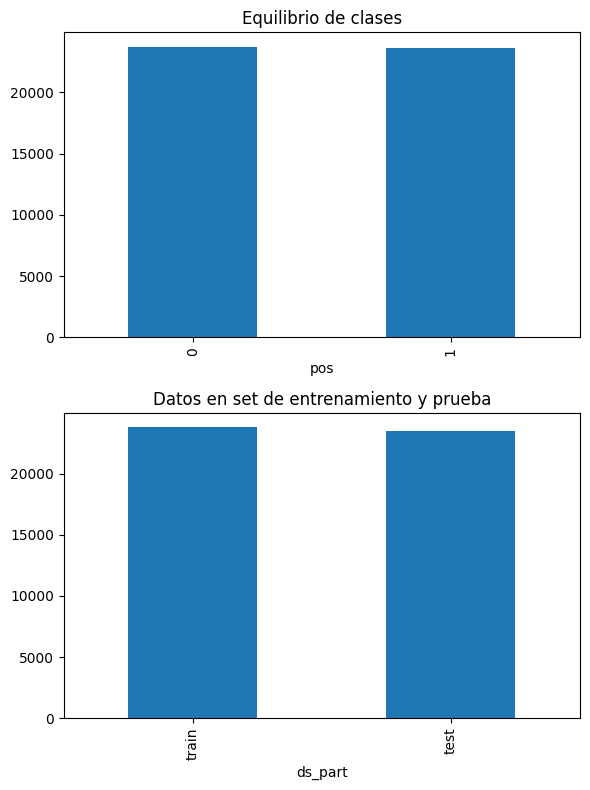

In [6]:
plt.figure(figsize=[6,8])

plt.subplot(211)
# Conteo de clases
df['pos'].value_counts().plot(kind='bar')
plt.title('Equilibrio de clases')

plt.subplot(212)
# Distribución de datos para entrenamiento y prueba
df['ds_part'].value_counts().plot(kind='bar')
plt.title('Datos en set de entrenamiento y prueba')

plt.tight_layout()

<span style=color:orange> **Comentario** </span >

- Se mantuvo la integridad de los datos originales en la selección de las columnas recomendadas.
- Existe equilibrio entre las clases 0 y 1.
- Las reseñas requieren de transfromación a minúsculas.
- La cantidad de datos destinada para entrenamiento y prueba está equilibrada. 

In [7]:
# Separación de datos para entrenamiento y prueba
train = df.query('ds_part == "train"')
test = df.query('ds_part == "test"')

target_train = train['pos']
target_test = test['pos']

## Procesamiento de datos

### Crear corpus

In [8]:
# Selección de todas las reseñas juntas
corpus = df['review']

In [9]:
# Poner en minúsculas el corpus
corpus = corpus.str.lower()
corpus.sample(5)

44024    this is one of my favorite horror films of all...
36042    i have tried watching this show on several dif...
9172     i generally love srk as a villain (how can you...
5868     bruce almighty is the best jim carrey work sin...
31529    veteran sleazeball bruno mattei is at it again...
Name: review, dtype: object

### Limpieza de textos del corpus

In [10]:
# Función para limpiar los textos del corpus
def text_cleaner(data):
    text_clean = re.sub(r'[^a-zA-Z\']', " ", data) # Quitar y cambiar caracteres que no sean letras
    text_clean = re.sub(r' \* ', " ", text_clean) # Quitar y cambiar símbolo *
    text_clean = re.sub(r' \- ', " ", text_clean) # Quitar y cambiar símbolo -
    text_clean = re.sub(r' \w ', " ", text_clean) # Quitar y cambiar letras sueltas
    letras = ['a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','w','x','y','z']
    for letra in letras: # Eliminar las letras que se repiten más de 3 veces, para evitar eliminar diptongos como "oo" o "ee"
        patron = "{}".format(letra) + "{3,}"
        text_clean = re.sub(patron, letra, text_clean)

    text_clean = " ".join(text_clean.split()) # Unir con un solo espacio

    return text_clean

In [11]:
# Aplicar la función al corpus
corpus_clean = corpus.apply(text_cleaner)

In [12]:
# Prueba de función, con dos ejemplos seleccionados
print('Texto original con letras repetidas:', corpus[34780])
print('Texto limpiado:', corpus_clean[34780])
print()
print('Texto original con **:', corpus[24705])
print('Texto limpiado:', corpus_clean[24705])

Texto original con letras repetidas: boooooooorrrrrinngggggggg and stooooooopiddddd. kept falling asleep. if you want to see miles o'keefe loping around in a furry speedo by all means rent this movie. if not please don't bother... rife with anachronisms. was this supposed to be set in the ice age, the iron age, the steel age or the age of reason? what was the reason for the black nylon wig on the guy dressed up as genghis khan? was that really supposed to be genghis khan? if ator had access to so much advanced technology and science why did we have wait another 1000 years for leonardo? it's never clear where ator comes from or if he's supposed to be some superior sort of being. you wonder if it was all explained in the first movie but after seeing this one you know you'll never bother.
Texto limpiado: borinng and stopid kept falling asleep if you want to see miles o'keefe loping around in furry speedo by all means rent this movie if not please don't bother rife with anachronisms was th

### Lematizar el corpus

In [13]:
nlp_en = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [14]:
# Funcion para lematizar
def lematizar(data):

    texto = nlp_en(data)

    lemas = []
    for word in texto:
        lemas.append(word.lemma_)
    
    text_lemma = " ".join(lemas)

    return text_lemma

In [15]:
# Lematizar corpus en lotes de 1000
batch_size = 1000

corpus_lema = []

for i in range(0, len(corpus_clean), batch_size):
    lote = corpus_clean[i:i + batch_size]

    for texto in lote:
        lemas = lematizar(texto)
        corpus_lema.append(lemas)


In [16]:
# Prueba de lematización
print('Texto original:', corpus[34780])
print('Texto lematizado:', corpus_lema[34780])

Texto original: boooooooorrrrrinngggggggg and stooooooopiddddd. kept falling asleep. if you want to see miles o'keefe loping around in a furry speedo by all means rent this movie. if not please don't bother... rife with anachronisms. was this supposed to be set in the ice age, the iron age, the steel age or the age of reason? what was the reason for the black nylon wig on the guy dressed up as genghis khan? was that really supposed to be genghis khan? if ator had access to so much advanced technology and science why did we have wait another 1000 years for leonardo? it's never clear where ator comes from or if he's supposed to be some superior sort of being. you wonder if it was all explained in the first movie but after seeing this one you know you'll never bother.
Texto lematizado: borinng and stopid keep fall asleep if you want to see mile o'keefe lope around in furry speedo by all mean rent this movie if not please do not bother rife with anachronism be this suppose to be set in the

In [17]:
# Conversión de los lemmas en Series
corpus_lema_ = pd.Series(corpus_lema)

In [18]:
# Corpus lematizado de entrenamiento
corpus_train = corpus_lema_.loc[train.index]

# Corpus lematizado de prueba
corpus_test = corpus_lema_.loc[test.index]

## Ingeniería de textos

### Codificación TF - IDF

In [19]:
# Crear modelo de codificación TF-IDF
count_tfidf = TfidfVectorizer(stop_words=stopwords.words("english"))
tfidf = count_tfidf.fit_transform(corpus_train)

In [20]:
# Selección de características de entrenamiento
features_train = tfidf

# Selección de características de prueba
features_test = count_tfidf.transform(corpus_test)

## Modelos de clasificación

### Regresión logística

In [ ]:
# Crear modelo
modelo_reg = LogisticRegression()

In [ ]:
# Ajuste de modelo con datos de entrenamiento
modelo_reg.fit(features_train, target_train)

LogisticRegression()

In [24]:
# Predicciones con set de pruebas
pred_reg = modelo_reg.predict(features_test)

In [42]:
# Métrica
print('F1_score:', round(f1_score(target_test, pred_reg), 4))

F1_score: 0.8782


### Bosque aleatorio

In [32]:
# Crear modelo con valores estándar
modelo_ba = RandomForestClassifier(random_state=42)

In [33]:
# Ajuste de modelo con datos de entrenamiento
modelo_ba = modelo_ba.fit(features_train, target_train)

In [34]:
# Predicciones con set de pruebas
pred_ba = modelo_ba.predict(features_test)

In [40]:
# Métrica
print('F1_score:', round(f1_score(target_test, pred_ba), 4))

F1_score: 0.8447


In [ ]:
# Definir espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Crear un objeto de puntuación f1
f1_scorer = make_scorer(f1_score, average='macro') # Los datos no están desbalanceados

# Crear y ajustar RandomizedSearchCV
clf = RandomForestClassifier(random_state=42)
random_search = RandomizedSearchCV(
    estimator=clf,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring=f1_scorer, # Uso del objeto f1_scorer
    random_state=42,
    n_jobs=-1
)
random_search.fit(tfidf, target_train)

# Obtener el mejor modelo
best_clf = random_search.best_estimator_

# Hacer predicciones y evaluar
pred_rf = best_clf.predict(features_test)
f1 = f1_score(target_test, pred_rf, average='macro') # para datos no desbalanceados
print(f"F1-score del mejor modelo: {f1}")
print(f"Mejores hiperparámetros: {random_search.best_params_}")

F1-score del mejor modelo: 0.8469029673990883
Mejores hiperparámetros: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}


### LGBM

In [27]:
# Definir y ajustar modelo GBM con valores estándar
lgbm = LGBMClassifier(
    verbose=-1,
    random_state=12345,
    learning_rate=0.1,
    n_estimators=100,
    reg_alpha=0,
    reg_lambda=0
).fit(tfidf, target_train)

In [28]:
# Predicción con set de pruebas
pred_lgbm = lgbm.predict(features_test)

In [43]:
# Métrica
print('F1_score:', round(f1_score(target_test, pred_lgbm), 4))

F1_score: 0.8563


<span style=color:orange> **Comentario** </span >

- Los modelos de regresión logística y LGBM lograron superar el valor de F1 mínimo requerido (0.85), con 0.8782 y 0.8563, respectivamente.
- La optimización del bosque aleatorio no alcanzó el valor mínimo del score f1.

## Conclusiones

- Lematizar los datos en lotes disminuyó el tiempo del proceso
- El mejor score f1 se obtuvo con el modelo de regresión logística, 0.8782
- La optimización de los hiperparámetros del bosque aleatorio no mejoraron de forma relevante la métrica f1, respecto a los hiperparámetros estándar. Tampoco superaron la métrica f1 obtenida por la regresión logística, por lo que ya no se intentaron nuevas optimizaciones. 
- Si bien, el modelo LGBM superó el valor mínimo requerido del score f1, la simplicidad y mejores resultados de la regresión logística lo hacen mejor opción para los objetivos del proyecto.  